In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

## Testing effect of scale

In [7]:
df = pd.read_csv('csvs/testing.csv')

In [8]:
df.head()

,Unnamed: 0,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,0,200.0,0.001000,100.0,0.014182,0.000200,70.965206,29.984037,0.0,29.990132,0.116455,59.668233,59.680364,0.502513,1.000141,0.159291,0.160614,0.991840
1,1,200.0,0.001000,200.0,0.014182,0.000199,71.253745,59.968073,0.0,59.887231,0.222645,59.668233,59.587795,1.005025,1.001667,0.159291,0.160400,0.993152
2,2,200.0,0.001000,400.0,0.014182,0.000200,71.059946,119.936146,0.0,120.065863,0.505163,59.668233,59.732767,2.010050,0.999322,0.159291,0.160426,0.992984
3,3,200.0,0.001551,100.0,0.014182,0.000482,29.449322,29.984037,0.0,30.053777,0.173707,59.668233,59.807016,0.502513,0.998435,0.159291,0.162278,0.981744
4,4,200.0,0.001551,200.0,0.014182,0.000479,29.626519,59.968073,0.0,59.987236,0.329787,59.668233,59.687300,1.005025,1.000373,0.159291,0.162432,0.980830


In [9]:
list = (df['Signal_Power'] / df['Scale_Param']).values

In [10]:
set(list)

{3.5454017756941e-05, 7.0908035513882e-05, 0.000141816071027764}

In [11]:
df['Signal_to_scale'] = df['Signal_Power'] / df['Scale_Param']

In [12]:
df['Signal_to_scale'].unique() / min(df['Signal_to_scale'].unique())

array([4., 2., 1.])

In [13]:
scale_values = df['Scale_Param'].unique()

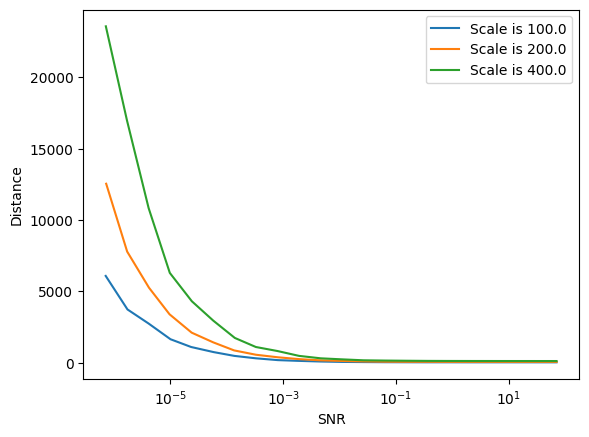

In [14]:
d = {}
for scale in scale_values:
    df_subset = df[df['Scale_Param'] == scale]
    plt.plot(df_subset['SNR'], df_subset['Distances_Noised'], label=f'Scale is {scale}')
    d[scale] = df_subset['Distances_Noised'].values
plt.xscale('log')
plt.xlabel('SNR')
plt.ylabel('Distance')
plt.legend()
plt.show()

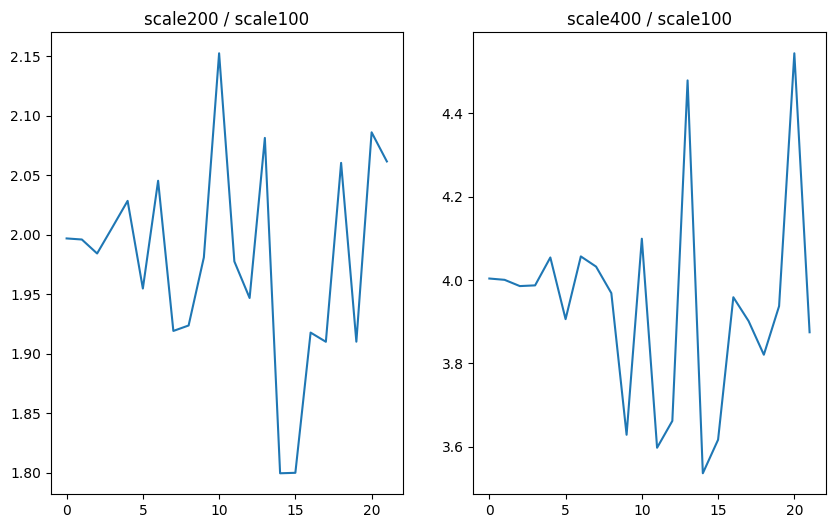

In [15]:
fig = plt.figure(figsize=(10,6))

fig.add_subplot(1,2,1)
plt.title('scale200 / scale100')
plt.plot(d[200] / d[100])

fig.add_subplot(1,2,2)
plt.title('scale400 / scale100')
plt.plot(d[400] / d[100])

Seeing this, I think it should make sense to use scale=1, just so we don't get too much problems with high values. Not sure why I used such high scale values so far.
We can use it since we can see that increasing the scale times X is the same as increasing the distance by X. Therefore, we don't mind using the same scale for all samples. - 24/10

## EMD between Gaussians

Try to add an estimation of how the function we see

In [28]:
df = pd.read_csv('csvs/results_measures_SNR_test.csv')

In [29]:
resolutions = df['Res'].unique()

### Interactive calculations

1 - EMD as a function of 1/SNR for an interactive resolution

2 - L2 as a function of 1/SNR for different resolutions

In [4]:
def interactive_distance(index):
    param = resolutions[index]
    df_subset = df[(df['Res'] == unique_res[index]) & (df['SNR'] > 0.1)]
    plt.figure(figsize=(6, 4))

    x = 1 / df_subset['SNR'].values
    y_noised = df_subset['Distances_Noised'].values
    y_classic = df_subset['Distances_Classic'].values

    a,b = np.polyfit(x, y_noised, 1)
    approx = a * x + b
    
    plt.plot(x, y_noised, label='Distance')
    plt.plot(x, approx, label='Fitted Log funcion')
    plt.plot(x, y_classic, label='Distance between measures without noise')
    plt.title(f'Resolution is {param}')
    plt.xscale('log')
    plt.xlabel('1 / SNR')
    plt.legend()
    plt.show()

In [5]:
resolutions= df['Res'].unique()

In [18]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(resolutions) - 1,
    step=1,
    description='Noise Index:',
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '470px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=9), Output(l…

In [17]:
def interactive_distance(index):
    param = resolutions[index]
    df_subset = df[(df['Res'] == unique_res[index]) & (df['SNR'] > 0.001)]
    plt.figure(figsize=(10, 6))

    x = 1 / df_subset['SNR'].values
    sqrt_x = np.sqrt(x)
    y_distances_linear_noised = df_subset['Distances_Linear_Noised'].values
    y_distances_linear_classic = df_subset['Distances_Linear'].values

    a, b = np.polyfit(sqrt_x, y_distances_linear_noised, 1)
    approx = a * np.sqrt(x) + b
    
    plt.plot(x, y_distances_linear_classic, label='L2')
    plt.plot(x, y_distances_linear_noised, label='L2 Noised')
    plt.plot(x, approx, label='Approximation using sqrt')    
    plt.title(f'Resolution is {param}')
    plt.xlabel('1 / SNR')
    plt.legend()
    plt.show()

In [19]:
index_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(resolutions) - 1,
    step=1,
    description='Noise Index:', 
    continuous_update=False,
    readout=True
)

# Create an interactive plot with a slider for noise_param
interactive_plot = interactive(interactive_distance, index=index_slider)
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='Noise Index:', max=9), Output(l…

### Trying to fit an exponent to distance as a function of 1/SNR

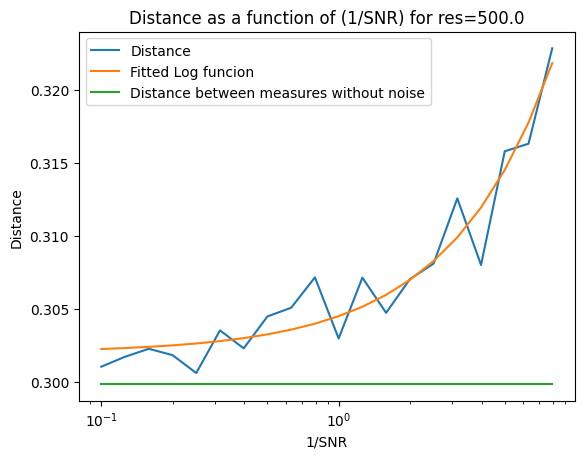

In [31]:
res_index = 4

df_subset = df[(df['Res'] == resolutions[res_index]) & (df['SNR'] > 0.1)]

x = 1 / df_subset['SNR'].values
# x = df_subset['SNR'].values
y_noised = df_subset['Distances_Noised']
y_classic = df_subset['Distances_Classic']

x_log = np.log(x)

#Polynomial of degree 1
a, b = np.polyfit(x, y_noised, 1)
approx = a * x + b

# Polynomial of degree 2
# a, b, c = np.polyfit(x_log, y_noised, 2)
# approx = a * (x_log ** 2) + b * x_log + c

plt.plot(x, y_noised, label='Distance')
plt.plot(x, approx, label='Fitted Log funcion')
plt.plot(x, y_classic, label='Distance between measures without noise')
# print(1 / df_subset['SNR'].values)
plt.legend()
plt.title(f'Distance as a function of (1/SNR) for res={resolutions[res_index]}')
plt.xlabel('1/SNR')
plt.ylabel('Distance')
plt.xscale('log')

### Looking at the effects of different resolutions on Distance for SNR>0.1

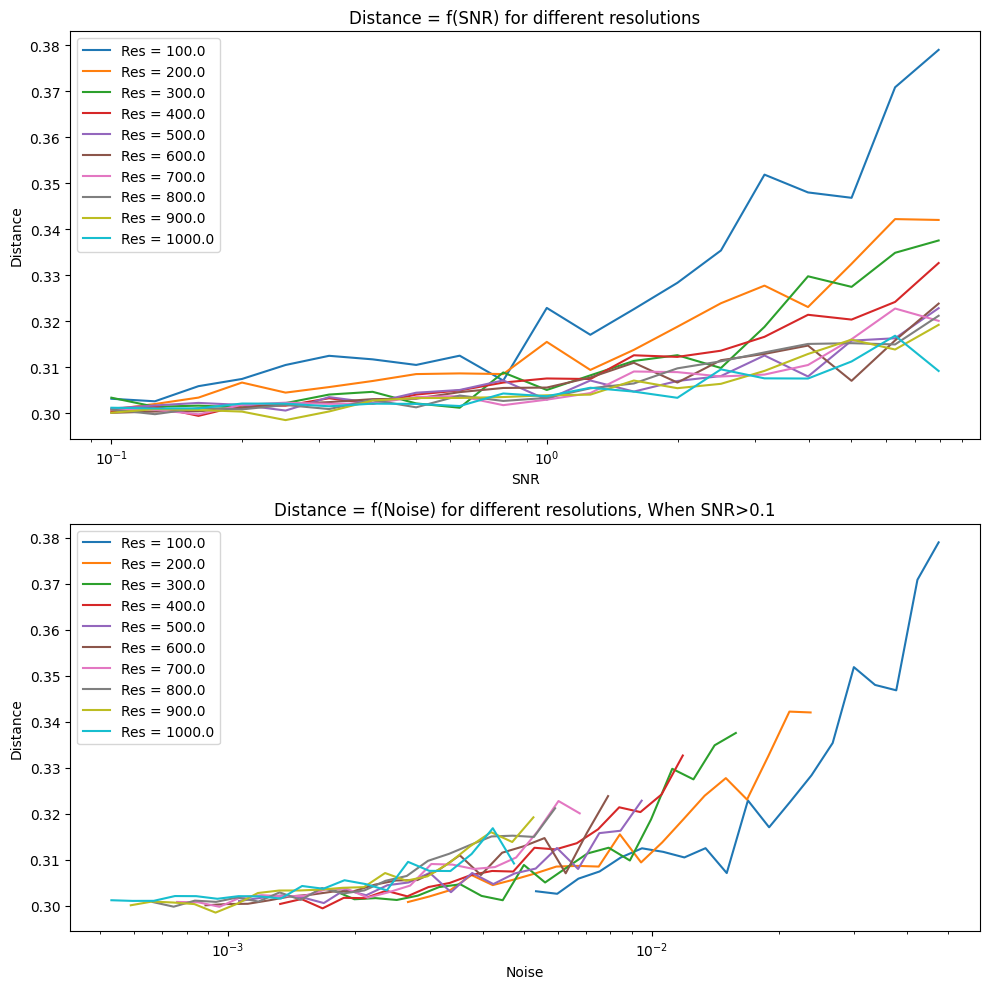

In [18]:
d = {}
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

for res in resolutions:
    df_subset = df[(df['Res'] == res) & (df['SNR'] > 0.1)]
    
    x_values_SNR = 1 / df_subset['SNR'].values
    x_values_noise = df_subset['Noise_Param'].values
    y_noised = df_subset['Distances_Noised'].values
    y_distances_linear_noised = df_subset['Distances_Linear_Noised'].values
    y_distances_linear_classic = df_subset['Distances_Linear'].values
    
    ax1.plot(x_values_SNR, y_noised, label=f'Res = {res}')
    d[res] = df_subset['Distances_Noised'].values
    ax2.plot(x_values_noise, y_noised, label=f'Res = {res}')
    ax2.plot



ax1.set_xscale('log')
# ax1.invert_xaxis()
ax1.set_title('Distance = f(SNR) for different resolutions')
ax1.set_xlabel('SNR')
ax1.set_ylabel('Distance')
ax1.legend()

ax2.set_xscale('log')
ax2.set_title('Distance = f(Noise) for different resolutions, When SNR>0.1')
ax2.set_xlabel('Noise')
ax2.set_ylabel('Distance')
ax2.legend()

plt.tight_layout()
plt.show()

### Exploring the df again

finding the ratio between SNR and Noise, seeing that $SNR \propto \frac{1}{noise^{2}}$

approximating the emd given the SNR



In [22]:
df.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,100.0,0.168835,1.0,0.028505,2.839533,0.010000,0.299855,8.134986e-18,0.802171,0.052528,29.685607,79.414936,0.010101,0.443545,0.225836,2.381240,0.095384
1,100.0,0.150474,1.0,0.028505,2.270433,0.012589,0.299855,8.134986e-18,0.717230,0.043081,29.685607,71.005808,0.010101,0.482133,0.225836,2.128228,0.106679
2,100.0,0.134111,1.0,0.028505,1.800316,0.015849,0.299855,8.134986e-18,0.697553,0.045570,29.685607,69.057736,0.010101,0.514268,0.225836,1.911670,0.118757
3,100.0,0.119526,1.0,0.028505,1.414793,0.019953,0.299855,8.134986e-18,0.631976,0.041601,29.685607,62.565594,0.010101,0.576613,0.225836,1.687149,0.134528
4,100.0,0.106528,1.0,0.028505,1.129295,0.025119,0.299855,8.134986e-18,0.540224,0.035795,29.685607,53.482194,0.010101,0.672475,0.225836,1.510637,0.150223


In [23]:
SNR_values = df['SNR'].unique()

In [24]:
approximated_distances_df = pd.DataFrame()
scales = df['Scale_Param'].unique()
scale = scales[0]

SNR_values = SNR_values[10:]

for res in unique_res:
    df_subset = df[(df['Res'] == res) & (df['Scale_Param']==scale) & (df['SNR'] >= 0.1)]
    # print(len(relevant_row.index))
       
    x = 1 / df_subset['SNR'].values
    y_noised = df_subset['Distances_Noised']
    for SNR in SNR_values:
        a, b = np.polyfit(x, y_noised, 1)

        relevant_row = df_subset[df_subset['SNR'] == SNR]
        approx = a * (1/relevant_row['SNR']) + b
        classic_distance = relevant_row['Distances_Classic'].values
        noised_distance = relevant_row['Distances_Noised'].values 
        
        new_row = {
            'Scale' : scale,
            'Res' : res,
            'Noise' : relevant_row['Noise_Param'].values[0],
            'SNR' : relevant_row['SNR'].values[0],
            'Distance_Without_Noise' : classic_distance[0],
            'Distance_With_Noise' : noised_distance[0],
            'Distance_With_Noise_Bound' : approx.values[0],
            'Ratio' : (noised_distance / approx).values[0],
            'a' : a,
            'b' : b
        }
            
        approximated_distances_df = approximated_distances_df._append(new_row, ignore_index=True)

In [25]:
len(approximated_distances_df.index)

210

In [26]:
len(df_subset.index)

21

Text(0, 0.5, 'SNR')

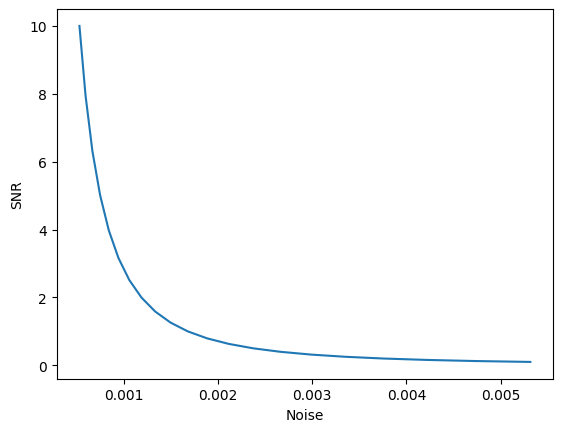

In [27]:
plt.plot(df_subset['Noise_Param'], df_subset['SNR'].values)
plt.xlabel('Noise')
plt.ylabel('SNR')
#plt.xscale('log')

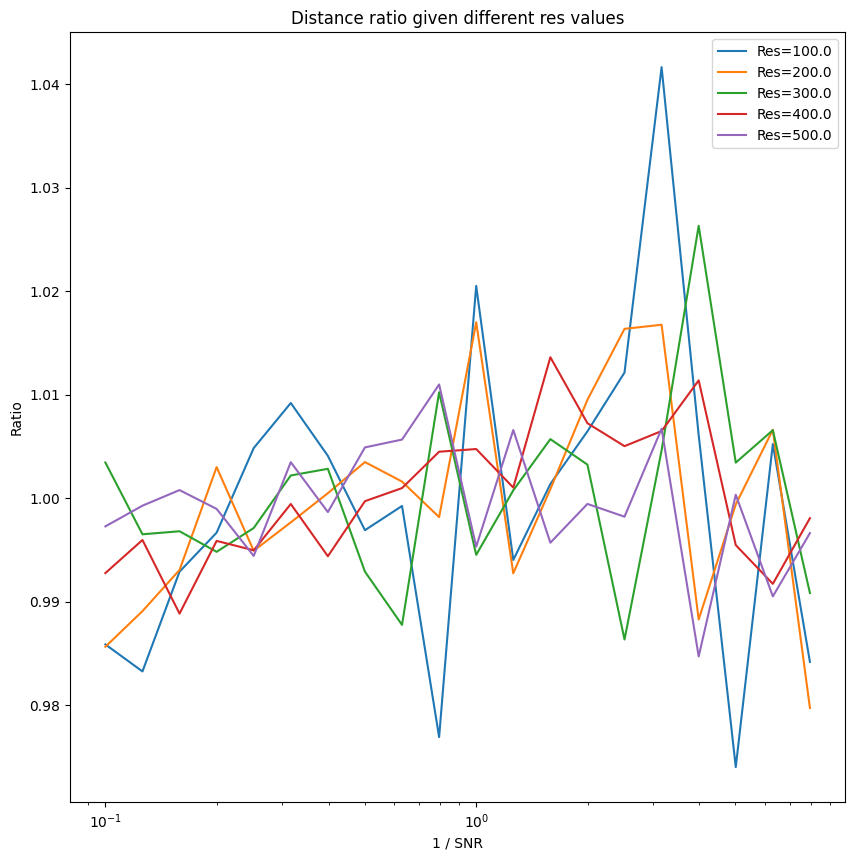

In [28]:
plt.figure(figsize=(10,10))

for i in range(5):
    subset = approximated_distances_df[(approximated_distances_df['Res'] == resolutions[i]) & (approximated_distances_df['SNR'] > 0.1)]
    # x = subset['SNR'].values
    x = 1 / subset['SNR'].values
    plt.plot(x, subset['Ratio'],
         label = f'Res={resolutions[i]}')
plt.title('Distance ratio given different res values')
plt.xscale('log')
plt.xlabel('1 / SNR')
plt.ylabel('Ratio')
plt.annotate('The option becomes equivalent to pure noise', xy=(40, 0.95), xytext = (100, 0.93), arrowprops=dict(facecolor='black', arrowstyle='->'),
             horizontalalignment='right')
plt.legend()
plt.show()

In [29]:
approximated_distances_df.head()

,Scale,Res,Noise,SNR,Distance_Without_Noise,Distance_With_Noise,Distance_With_Noise_Bound,Ratio,a,b
0,1.0,100.0,0.053390,0.100000,0.299855,0.407068,0.405372,1.004186,0.009884,0.306527
1,1.0,100.0,0.047584,0.125893,0.299855,0.378950,0.385042,0.984177,0.009884,0.306527
2,1.0,100.0,0.042409,0.158489,0.299855,0.370820,0.368894,1.005221,0.009884,0.306527
3,1.0,100.0,0.037797,0.199526,0.299855,0.346813,0.356067,0.974013,0.009884,0.306527
4,1.0,100.0,0.033687,0.251189,0.299855,0.347981,0.345878,1.006082,0.009884,0.306527


Higher 1/SNR means SNR is low and the option becomes equivalent to pure noise

lower 1/SNR means SNR is high, Thus meaning the noise is not significant and therefore we get some plateau

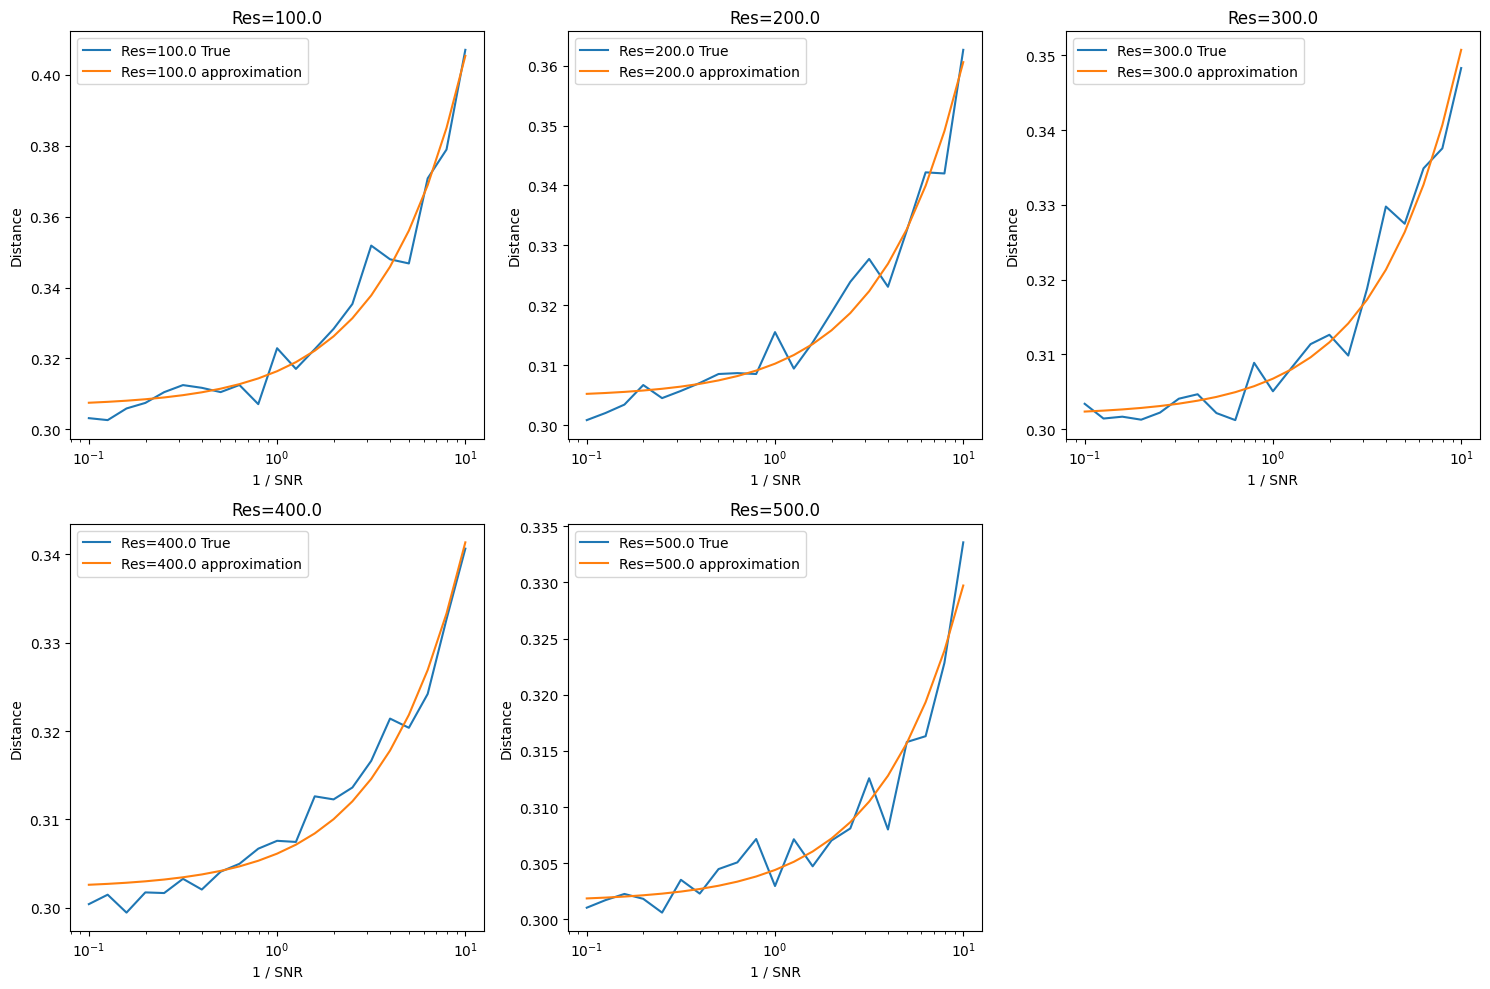

In [33]:
plt.figure(figsize=(15, 10)) 

for i in range(5):
    
    subset = approximated_distances_df[approximated_distances_df['Res'] == resolutions[i]]
    x = 1 / subset['SNR'].values
    
    # Arrange the plots in a 2x3 grid
    plt.subplot(2, 3, i + 1)
    
    plt.plot(x, subset['Distance_With_Noise'], label=f'Res={resolutions[i]} True')
    plt.plot(x, subset['Distance_With_Noise_Bound'], label=f'Res={resolutions[i]} approximation')
    plt.title(f'Res={resolutions[i]}')
    plt.xscale('log')
    plt.xlabel('1 / SNR')
    plt.ylabel('Distance')
    plt.legend()

plt.tight_layout()  # Adjusts the plots so that they don't overlap
plt.show()

## 11/11 - Finding the relationship between noise, resolution and SNR

In [32]:
df = pd.read_csv('csvs/results_measures_SNR_test.csv')

In [33]:
df.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,100.0,0.168835,1.0,0.028505,2.839533,0.010000,0.299855,8.134986e-18,0.802171,0.052528,29.685607,79.414936,0.010101,0.443545,0.225836,2.381240,0.095384
1,100.0,0.150474,1.0,0.028505,2.270433,0.012589,0.299855,8.134986e-18,0.717230,0.043081,29.685607,71.005808,0.010101,0.482133,0.225836,2.128228,0.106679
2,100.0,0.134111,1.0,0.028505,1.800316,0.015849,0.299855,8.134986e-18,0.697553,0.045570,29.685607,69.057736,0.010101,0.514268,0.225836,1.911670,0.118757
3,100.0,0.119526,1.0,0.028505,1.414793,0.019953,0.299855,8.134986e-18,0.631976,0.041601,29.685607,62.565594,0.010101,0.576613,0.225836,1.687149,0.134528
4,100.0,0.106528,1.0,0.028505,1.129295,0.025119,0.299855,8.134986e-18,0.540224,0.035795,29.685607,53.482194,0.010101,0.672475,0.225836,1.510637,0.150223


In [34]:
SNR = df['SNR'].values

In [35]:
len(SNR)

310

In [36]:
len(set(SNR))

31

In [37]:
# Define the inverse power-law function.
def inverse_power_law(snr, a, b):
    return a / (snr ** b)

# Define the exponential decay function.
def exponential_decay(snr, a, b):
    return a * np.exp(-b * snr)

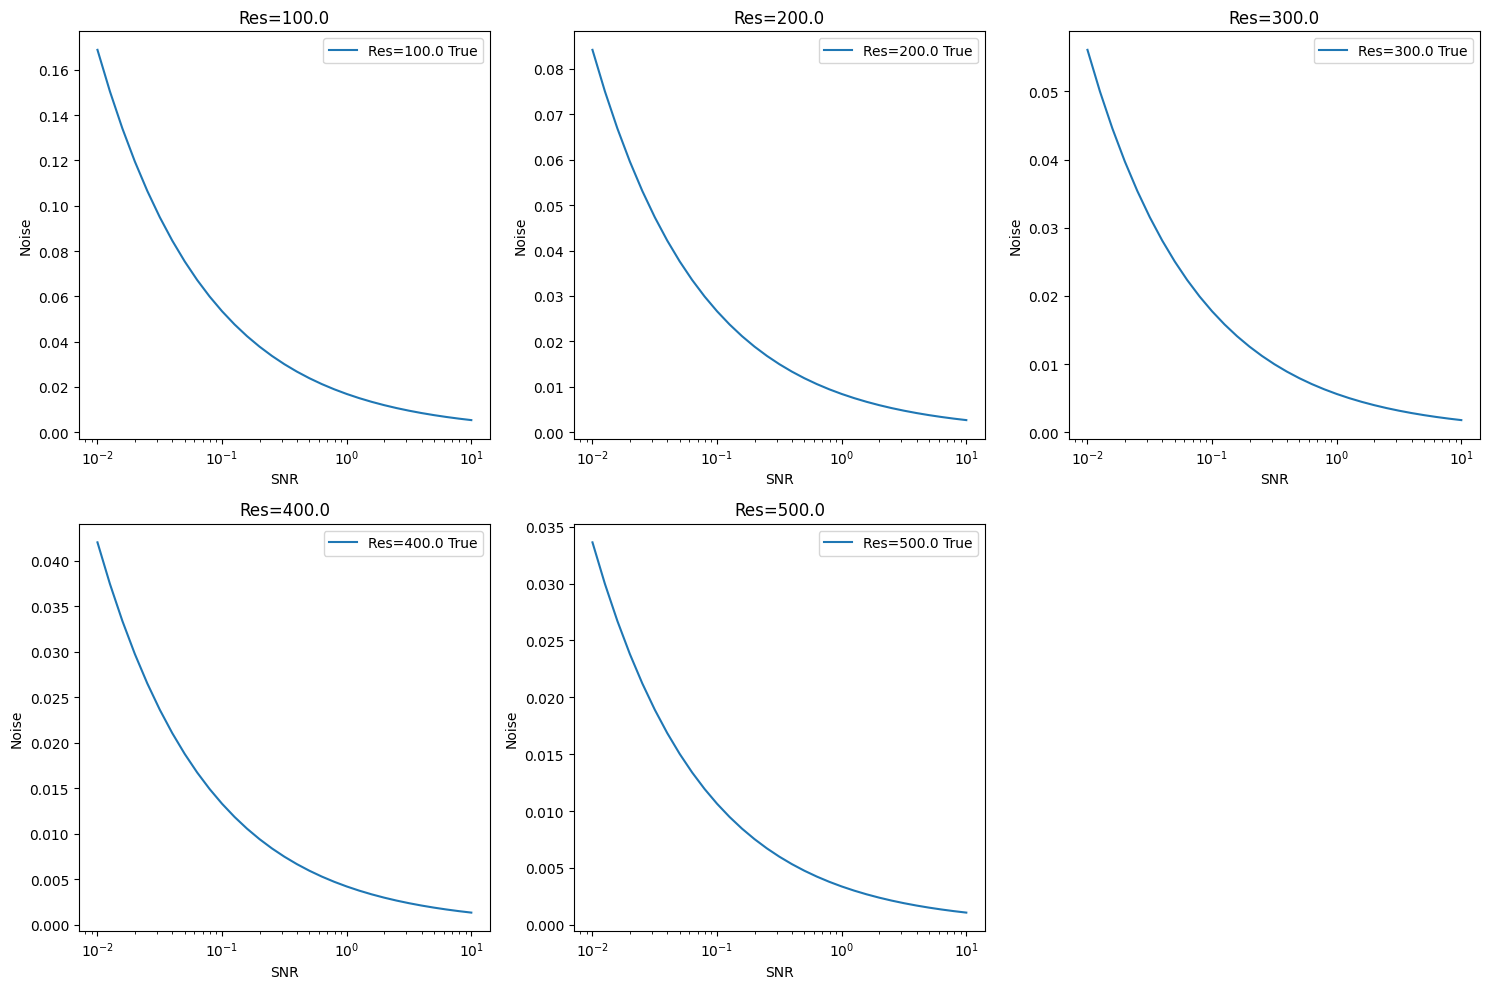

In [38]:
plt.figure(figsize=(15, 10)) 

for i in range(5):
    subset = df[df['Res'] == resolutions[i]]
    x = subset['SNR'].values
    
    # Arrange the plots in a 2x3 grid
    plt.subplot(2, 3, i + 1)
    
    plt.plot(x, subset['Noise_Param'], label=f'Res={resolutions[i]} True')
    plt.title(f'Res={resolutions[i]}')
    plt.xscale('log')
    plt.xlabel('SNR')
    plt.ylabel('Noise')
    
    # Annotate each subplot
    plt.annotate('The option becomes equivalent to pure noise', xy=(35000, 0.93), xytext = (20000, 0.93), arrowprops=dict(facecolor='black', arrowstyle='->'),
                 horizontalalignment='right')
    
    plt.legend()

plt.tight_layout()  # Adjusts the plots so that they don't overlap
plt.show()

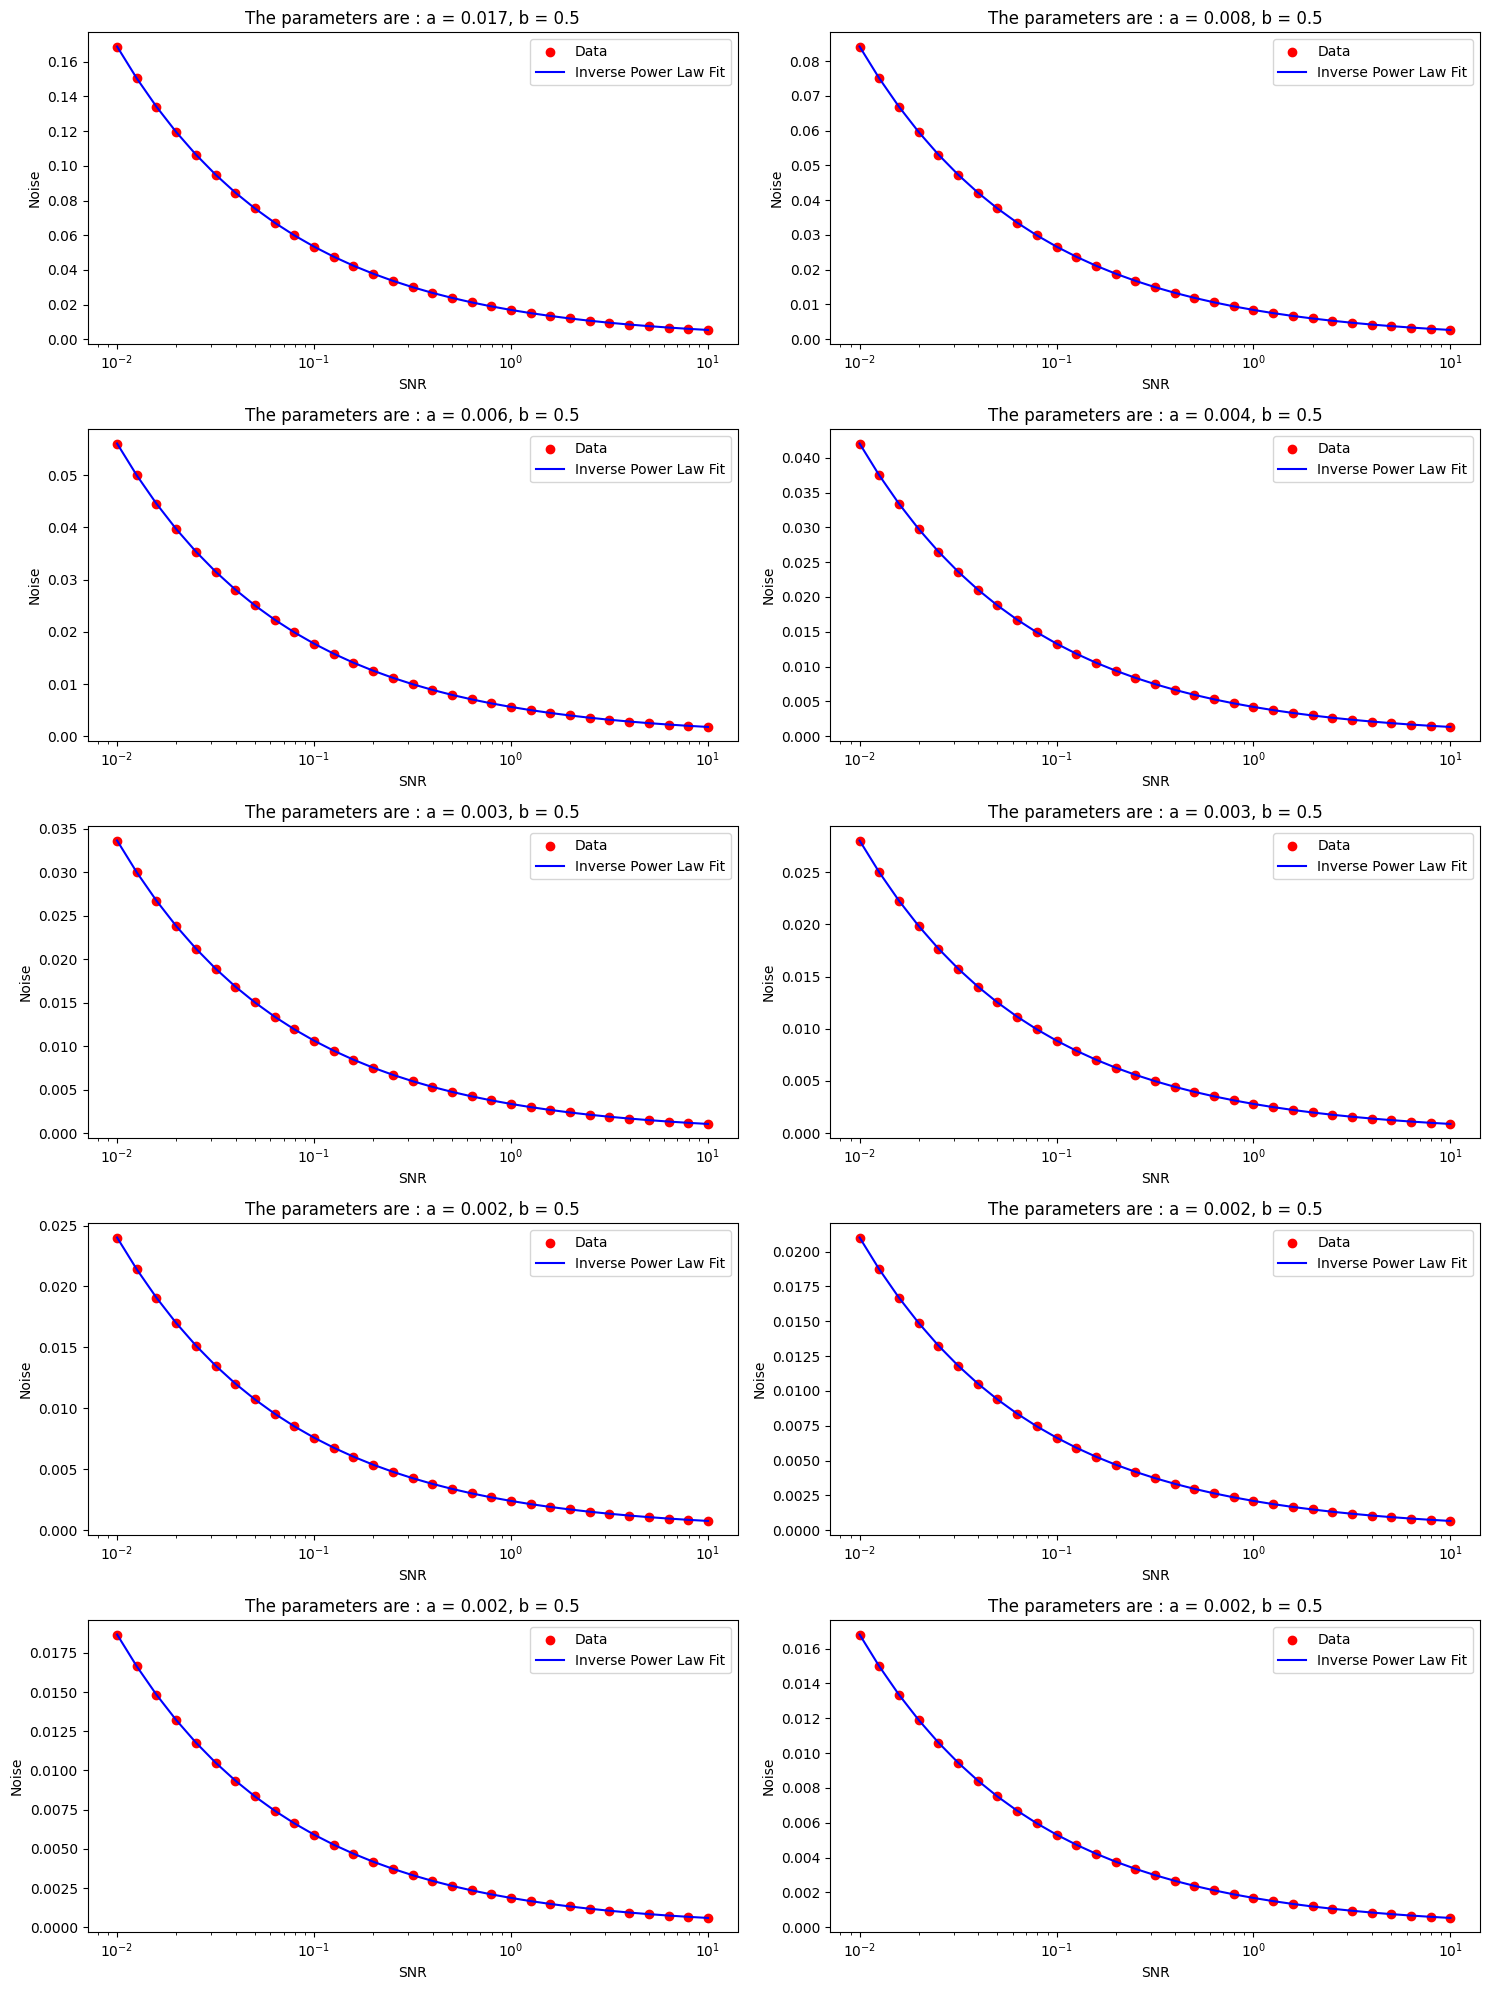

In [39]:
plt.figure(figsize=(15, 20)) 
amplitude_factors = []

for i in range(10):
    subset = df[df['Res'] == resolutions[i]]
    snr_values = subset['SNR'].values
    noise_levels = subset['Noise_Param']
    plt.subplot(5, 2, i + 1)
    
    # Fit the inverse power-law function to the data.
    params_power_law, covariance_power_law = curve_fit(inverse_power_law, snr_values, noise_levels)

    # Fit the exponential decay function to the data.
    params_exp_decay, covariance_exp_decay = curve_fit(exponential_decay, snr_values, noise_levels)

    # Generate fitted curves
    fitted_power_law = inverse_power_law(snr_values, *params_power_law)
    fitted_exp_decay = exponential_decay(snr_values, *params_exp_decay)


    plt.scatter(snr_values, noise_levels, label='Data', color='red')
    plt.plot(snr_values, fitted_power_law, label='Inverse Power Law Fit', color='blue')
    #plt.plot(snr_values, fitted_exp_decay, label='Exponential Decay Fit', color='green')
    plt.xlabel('SNR')
    plt.ylabel('Noise')
    plt.xscale('log')
    plt.title(f'The parameters are : a = {round(params_power_law[0], 3)}, b = {round(params_power_law[1], 3)}')
    amplitude_factors.append(params_power_law[0])
    plt.legend()

plt.tight_layout()  # Adjusts the plots so that they don't overlap
plt.show()

In [40]:
amplitude_factors

[0.01688351640861791,
 0.00842069091665772,
 0.005609137250314731,
 0.0042051101584856775,
 0.003363252481427864,
 0.00280224646186031,
 0.0024016416234665093,
 0.0021012501629257842,
 0.0018676491844396854,
 0.0016807915929572498]

[]

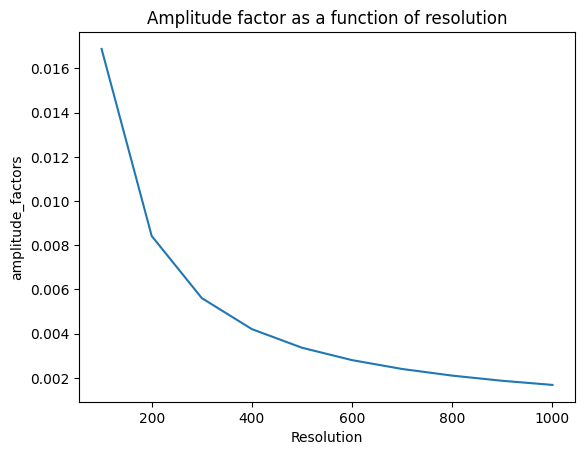

In [41]:
plt.plot(resolutions, amplitude_factors)
plt.ylabel('amplitude_factors')
plt.xlabel('Resolution')
plt.title('Amplitude factor as a function of resolution')
plt.plot()

In [42]:
resolution = resolutions

C:\Users\eriki\OneDrive\Documents\all_folder\Thesis\Thesis\venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


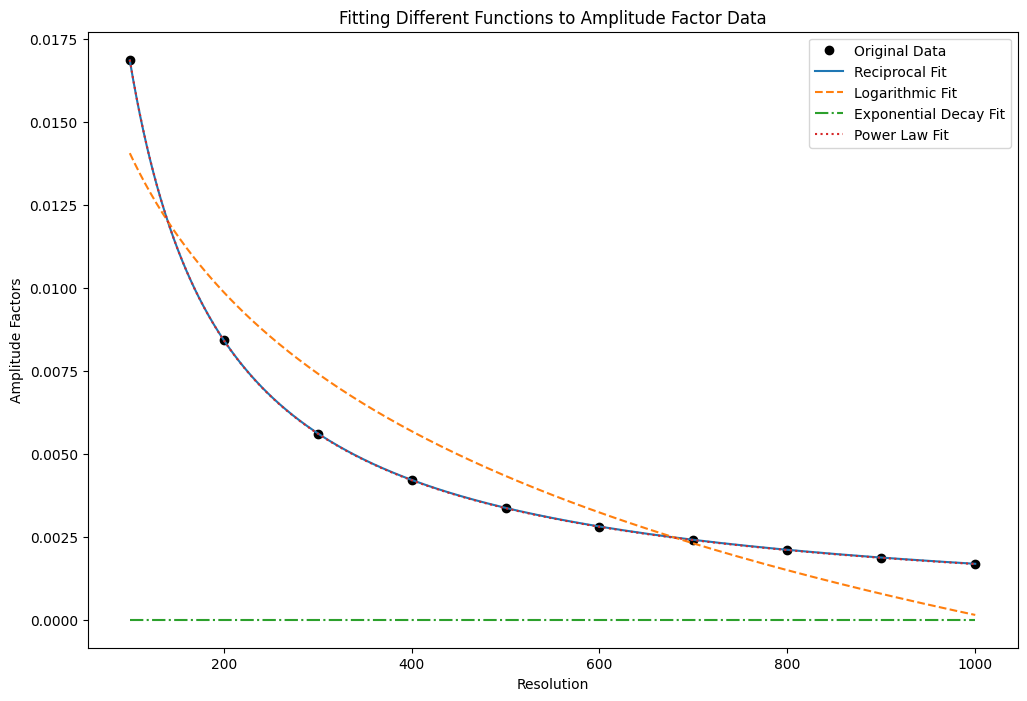

Reciprocal Fit Parameters: [1.68643898]
Logarithmic Fit Parameters: [-0.00604621  0.04190981]
Exponential Decay Fit Parameters: [1. 1.]
Power Law Fit Parameters: [1.7079241  1.00252997]
Sum of Residuals for Reciprocal Fit: 0.000000
Sum of Residuals for Logarithmic Fit: 0.000021
Sum of Residuals for Exponential Decay Fit: 0.000441
Sum of Residuals for Power Law Fit: 0.000000


In [43]:
# Define the various potential fitting functions
def reciprocal(x, k):
    return k / x

def logarithmic(x, k, c):
    return k * np.log(x) + c

def exponential_decay(x, k, c):
    return k * np.exp(-c * x)

def power_law(x, k, c):
    return k * x ** (-c)

# Fit each function to the data
params_reciprocal, _ = curve_fit(reciprocal, resolution, amplitude_factors)
params_logarithmic, _ = curve_fit(logarithmic, resolution, amplitude_factors)
params_exponential_decay, _ = curve_fit(exponential_decay, resolution, amplitude_factors)
params_power_law, _ = curve_fit(power_law, resolution, amplitude_factors)

# Generate fitted curves for each function
x_values = np.linspace(min(resolution), max(resolution), 1000)
fit_reciprocal = reciprocal(x_values, *params_reciprocal)
fit_logarithmic = logarithmic(x_values, *params_logarithmic)
fit_exponential_decay = exponential_decay(x_values, *params_exponential_decay)
fit_power_law = power_law(x_values, *params_power_law)

# Plot the original data and the fitted curves for each function
plt.figure(figsize=(12, 8))

plt.plot(resolution, amplitude_factors, 'ko', label='Original Data')
plt.plot(x_values, fit_reciprocal, '-', label='Reciprocal Fit')
plt.plot(x_values, fit_logarithmic, '--', label='Logarithmic Fit')
plt.plot(x_values, fit_exponential_decay, '-.', label='Exponential Decay Fit')
plt.plot(x_values, fit_power_law, ':', label='Power Law Fit')

plt.xlabel('Resolution')
plt.ylabel('Amplitude Factors')
plt.title('Fitting Different Functions to Amplitude Factor Data')
plt.legend()
plt.show()

# Print out the parameters for each fit
print("Reciprocal Fit Parameters:", params_reciprocal)
print("Logarithmic Fit Parameters:", params_logarithmic)
print("Exponential Decay Fit Parameters:", params_exponential_decay)
print("Power Law Fit Parameters:", params_power_law)

# To compare which fit is better, calculate the residuals for each
residuals_reciprocal = np.sum((amplitude_factors - reciprocal(resolution, *params_reciprocal))**2)
residuals_logarithmic = np.sum((amplitude_factors - logarithmic(resolution, *params_logarithmic))**2)
residuals_exponential_decay = np.sum((amplitude_factors - exponential_decay(resolution, *params_exponential_decay))**2)
residuals_power_law = np.sum((amplitude_factors - power_law(resolution, *params_power_law))**2)

# Print out the sum of residuals for each fit
print(f"Sum of Residuals for Reciprocal Fit: {residuals_reciprocal:.6f}")
print(f"Sum of Residuals for Logarithmic Fit: {residuals_logarithmic:.6f}")
print(f"Sum of Residuals for Exponential Decay Fit: {residuals_exponential_decay:.6f}")
print(f"Sum of Residuals for Power Law Fit: {residuals_power_law:.6f}")

We can conclude that the right fit is:

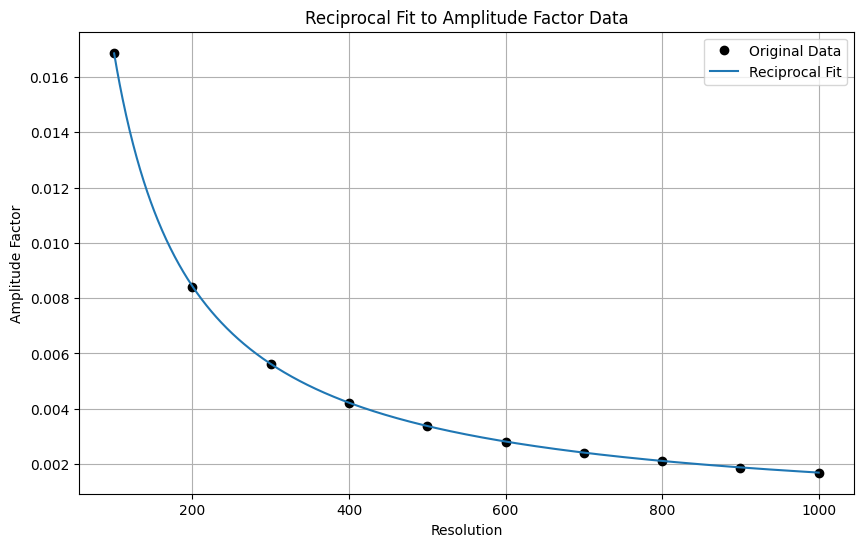

In [44]:
# Parameters for the reciprocal fit from previous output
k_reciprocal = 1.686

# Generate fitted curve for the reciprocal function
x_values = np.linspace(min(resolution), max(resolution), 1000)
fit_reciprocal = reciprocal(x_values, k_reciprocal)

# Plot the original data and the fitted reciprocal curve
plt.figure(figsize=(10, 6))
plt.plot(resolution, amplitude_factors, 'ko', label='Original Data')
plt.plot(x_values, fit_reciprocal, '-', label='Reciprocal Fit')

plt.xlabel('Resolution')
plt.ylabel('Amplitude Factor')
plt.title('Reciprocal Fit to Amplitude Factor Data')
plt.legend()
plt.grid(True)
plt.show()

The best fit is the reciprocal, which means that $a = \frac{k}{Res}$ and therefore we can say that $\epsilon = \frac{k}{Res * \sqrt{SNR}}$

## 18/11 Looking into whether EMD is more robust to noise than L2

In [45]:
df = pd.read_csv('csvs/results_measures_SNR_test.csv')
resolutions = df['Res'].unique()

In [46]:
df.head()

,Res,Noise_Param,Scale_Param,Signal_Power,Noise_Power,SNR,Distances_Classic,CI_Distances_Classic,Distances_Noised,CI_Distances_Noised,Cumsum_Classic,Cumsum_Noised,Ratios_emd_cumsum,Ratios_EMD,Distances_Linear,Distances_Linear_Noised,Ratios_Linear
0,100.0,0.168835,1.0,0.028505,2.839533,0.010000,0.299855,8.134986e-18,0.802171,0.052528,29.685607,79.414936,0.010101,0.443545,0.225836,2.381240,0.095384
1,100.0,0.150474,1.0,0.028505,2.270433,0.012589,0.299855,8.134986e-18,0.717230,0.043081,29.685607,71.005808,0.010101,0.482133,0.225836,2.128228,0.106679
2,100.0,0.134111,1.0,0.028505,1.800316,0.015849,0.299855,8.134986e-18,0.697553,0.045570,29.685607,69.057736,0.010101,0.514268,0.225836,1.911670,0.118757
3,100.0,0.119526,1.0,0.028505,1.414793,0.019953,0.299855,8.134986e-18,0.631976,0.041601,29.685607,62.565594,0.010101,0.576613,0.225836,1.687149,0.134528
4,100.0,0.106528,1.0,0.028505,1.129295,0.025119,0.299855,8.134986e-18,0.540224,0.035795,29.685607,53.482194,0.010101,0.672475,0.225836,1.510637,0.150223


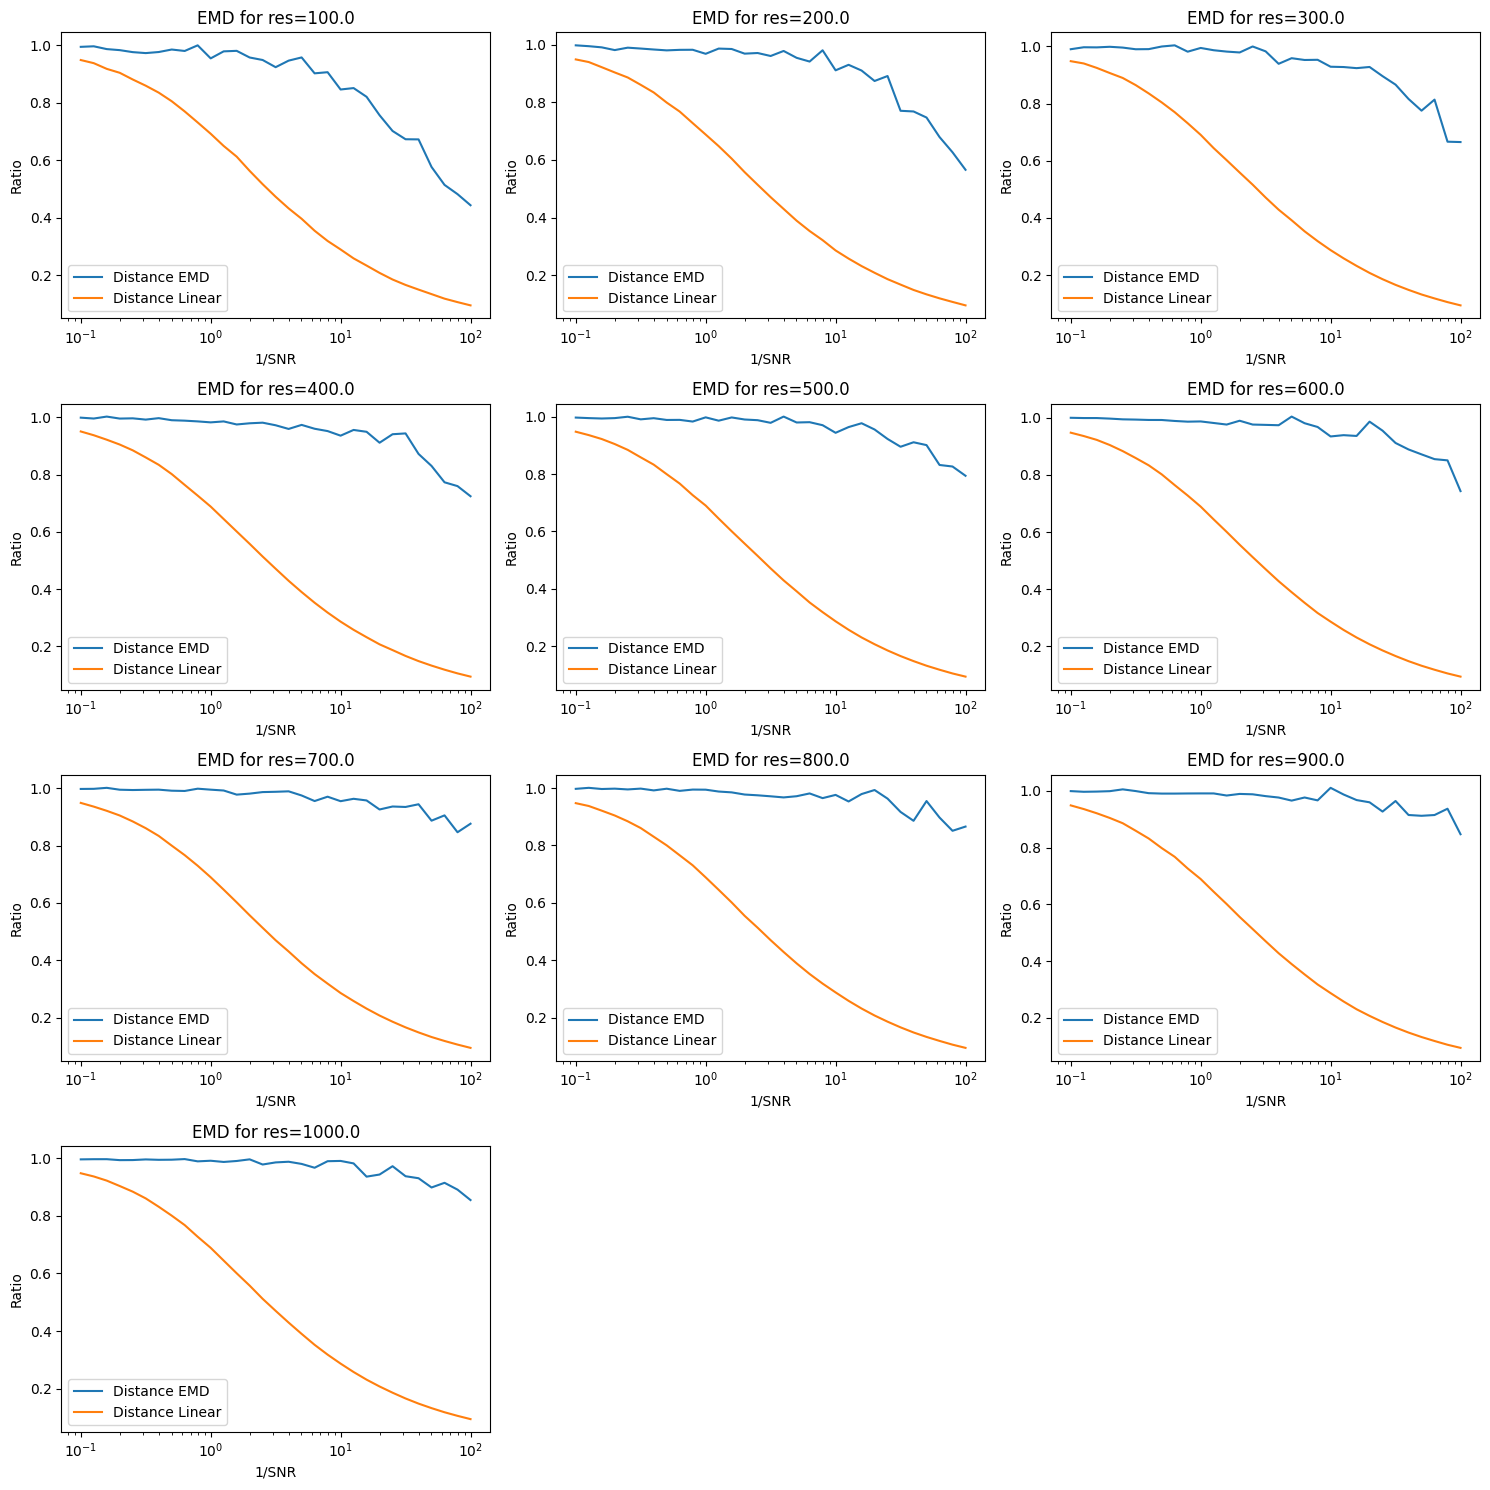

In [47]:
plt.figure(figsize=(15,15))

for i, res_option in enumerate(resolutions):
    # Filter the dataframe based on current 'res' and 'scale' options
    filtered_df = df[(df['Res'] == res_option)]
    plt.subplot(4, 3, i + 1)
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_EMD'], label='Distance EMD')
    plt.plot(1/filtered_df['SNR'], filtered_df['Ratios_Linear'], label='Distance Linear')
    plt.xscale('log')
    plt.title(f'EMD for res={res_option}')
    plt.xlabel('1/SNR')
    plt.ylabel('Ratio')
    plt.legend()

plt.tight_layout()
plt.show()